## Libraries Import

In [1]:
import sys

try:
    from library.synthetic_control import SyntheticControl
except ModuleNotFoundError:
    sys.path.append('/home/jupyter/datasphere')
    from library.synthetic_control import SyntheticControl

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import warnings
import pymc as pm
import arviz as az
import causalpy 
from patsy import build_design_matrices, dmatrices

from library.synthetic_control import SyntheticControl
from library.data_generator import generate_gaussian_process_data
from library.synthetic_did import SyntheticDIDModel
from library.synthetic_bayes import WeightedSumFitter


plt.style.use('ggplot')
warnings.filterwarnings("ignore")

## Data generation

In [3]:
N = 10     
T = 100     
T0 = 50       
effect = -5.0 
seed = 42

all_series = generate_gaussian_process_data(N=N, T=T, length_scale=2.0, seed=seed)

all_series[0, T0:] += effect

for i in range(1, N):
    all_series[i, :] += 2

df_list = []
for unit_idx in range(N):
    for time_idx in range(T):
        y_val = all_series[unit_idx, time_idx]
        treated_flag = (unit_idx == 0) 
        after_treatment_flag = (time_idx >= T0)
        df_list.append({
            "unit": unit_idx,
            "time": time_idx,
            "y": y_val,
            "treated": treated_flag,
            "after_treatment": after_treatment_flag
        })

data = pd.DataFrame(df_list)

data_bayes = data.pivot(index='time', columns='unit', values='y').reset_index(drop=True).rename_axis(None, axis=1)
data_bayes = data_bayes.rename(columns={0:'actual', 1:'a', 2:'b', 3:'c', 4:'d', 5:'e', 6:'f', 7:'g', 8:'h', 9:'i'})

## Frequentist approach

### Synthetic control example

Реализуем следующую модель с добавлением константы:

$$
\min_{\mathbf{w} \in \Delta_J, \alpha} \left\| \mathbf{y}_{\text{pre}}^{\text{tr}} - \alpha - \mathbf{Y}_{\text{pre}}^{\text{co}} \mathbf{w} \right\|_2^2
$$
где $\Delta_J$ обозначает $J$-мерное симплексное множество и оно удовлетворяет условию:

$$\Delta_J = \left\{ \mathbf{w} \in \mathbb{R}^{J} \,\bigg|\, w_j \ge 0, \; \sum_{j=1}^{J} w_j = 1 \right\}
$$

А $\alpha$ представляет собой константу (интерцепт), которая позволяет учитывать постоянное смещение между целевой единицей и контрольными единицами.

Код основан на статье: https://matheusfacure.github.io/python-causality-handbook/25-Synthetic-Diff-in-Diff.html#synthetic-controls-revisited

SC ATT: -4.7561
Веса синтетического контроля:
Индекс: 2, Значение: 0.42
Индекс: 4, Значение: 0.08
Индекс: 5, Значение: 0.13
Индекс: 6, Значение: 0.18
Индекс: 8, Значение: 0.18
Индекс: 9, Значение: 0.0


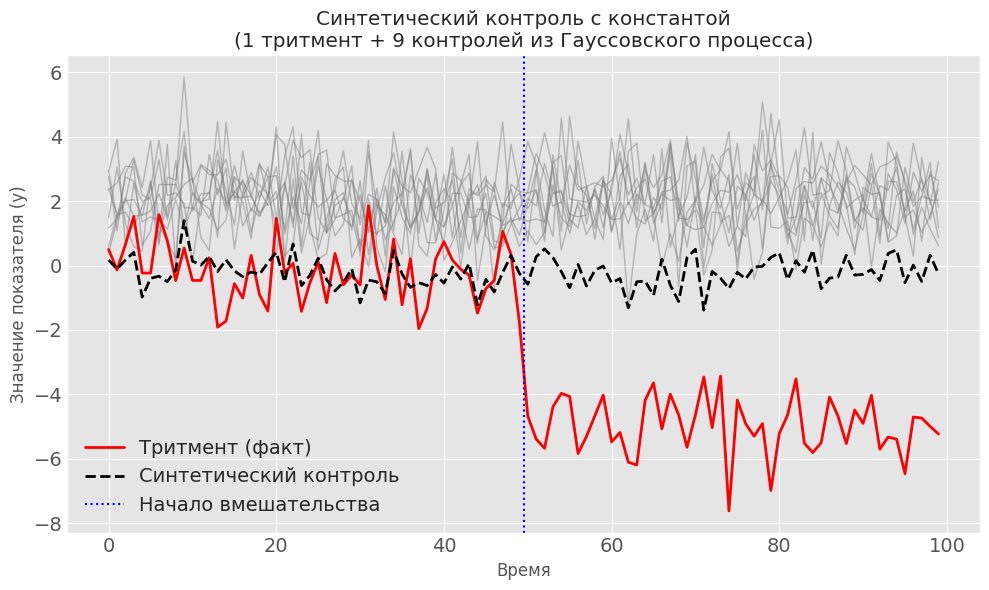

In [4]:
y_co_pre = (
    data.query("treated == False and after_treatment == False")
        .pivot(index="time", columns="unit", values="y")
)

y_tr_pre = (
    data.query("treated == True and after_treatment == False")
        .sort_values("time")["y"]
)

sc_model = SyntheticControl(add_constant=True) 
sc_model.fit(y_co_pre, y_tr_pre)

sc_weights = pd.Series(sc_model.w_, index=y_co_pre.columns, name="weights")

y_co_all = (
    data.query("treated == False")
        .pivot(index="time", columns="unit", values="y")
        .sort_index()
)

sc_full = sc_model.a_ + y_co_all.dot(sc_weights) 

y_tr_all = (
    data.query("treated == True")
        .sort_values("time")["y"]
    .reset_index(drop=True) 
)

att = y_tr_all[T0:].mean() - sc_full[T0:].mean()
print("SC ATT:", round(att, 4))

print("Веса синтетического контроля:")
sc_weights_reset = sc_weights.reset_index().rename(columns={'index': 'unit'})
for i in range(len(sc_weights_reset)):
    value = sc_weights_reset.loc[i, 'weights']
    if value > 0:
        print(f"Индекс: {sc_weights_reset.loc[i, 'unit']}, Значение: {round(value, 2)}")

fig, ax = plt.subplots(figsize=(10, 6))

controls_all = data.query("treated == False")
for unit_idx in controls_all["unit"].unique():
    subset = controls_all.query("unit == @unit_idx").sort_values("time")
    ax.plot(subset["time"], subset["y"], color="gray", alpha=0.5, linewidth=1)

treated_all = data.query("treated == True").sort_values("time")
ax.plot(treated_all["time"], treated_all["y"], color="red", label="Тритмент (факт)", linewidth=2)

ax.plot(sc_full.index, sc_full.values, color="black", linestyle="--",
        label="Синтетический контроль", linewidth=2)

ax.axvline(T0 - 0.5, color='blue', linestyle=':', label='Начало вмешательства')

ax.set_xlabel("Время")
ax.set_ylabel("Значение показателя (y)")
ax.set_title("Синтетический контроль с константой\n(1 тритмент + 9 контролей из Гауссовского процесса)")
ax.legend()
plt.tight_layout()
plt.show()


### Synthetic DIFF and DIFF example

$$
\hat{w}^{sdid} = \underset{w}{\mathrm{argmin}} \; \left\{ \Bigl\|\bar{{y}}_{pre,tr} - \bigl({Y}_{pre,co} \, {w}_{co} + w_0\bigr)\Bigr\|_2^2 + \zeta^2\, T_{pre}\, \Bigl\|{w}_{co}\Bigr\|_2^2 \right\}
$$

при условии, что $(\sum_i w_i = 1)$ и $(w_i > 0)$ для всех $i$, а также

$$
\zeta = \bigl(N_{tr} \, T_{post}\bigr)^{1/4} \, \sigma(\Delta_{it})
$$

Код основан на статье: https://matheusfacure.github.io/python-causality-handbook/25-Synthetic-Diff-in-Diff.html#synthetic-controls-revisited

SDID ATT: -4.7417
Веса синтетического контроля:
Индекс: 1, Значение: 0.1
Индекс: 2, Значение: 0.13
Индекс: 3, Значение: 0.1
Индекс: 4, Значение: 0.11
Индекс: 5, Значение: 0.11
Индекс: 6, Значение: 0.12
Индекс: 7, Значение: 0.1
Индекс: 8, Значение: 0.12
Индекс: 9, Значение: 0.11


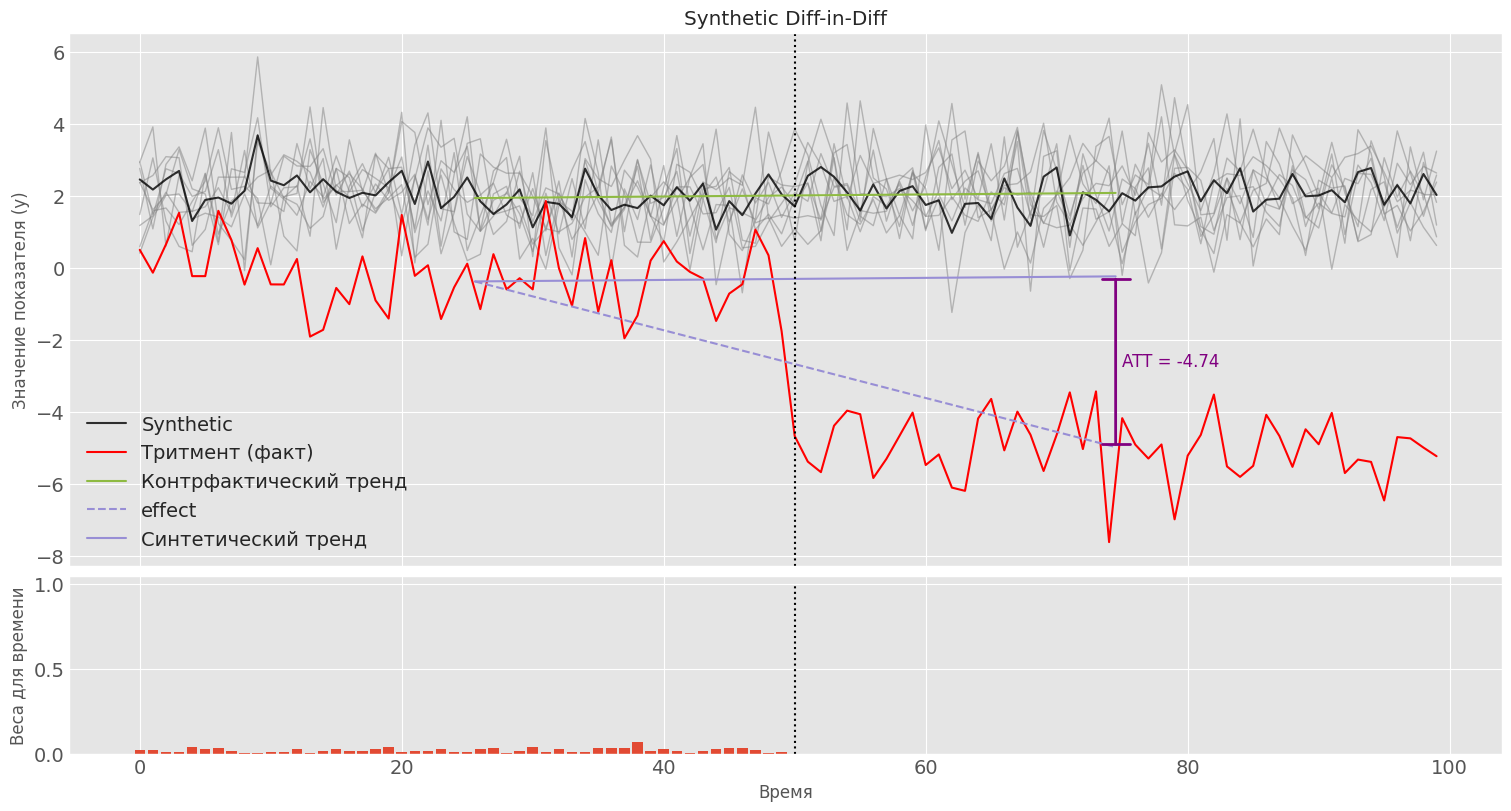

In [5]:
sc_did = y_co_all.dot(sc_weights) 
sdid_model = SyntheticDIDModel(
    data=data,
    outcome_col="y",
    period_index_col="time",
    shopno_col="unit",
    treat_col="treated",
    post_col="after_treatment"
)

att, unit_weights, time_weights, sdid_model_fit, intercept = sdid_model.synthetic_diff_in_diff()

print("SDID ATT:", round(att, 4))

print("Веса синтетического контроля:")
unit_weights_reset = unit_weights.reset_index()
for i in range(len(sc_weights_reset)):
    value = unit_weights_reset['unit_weights'][i]
    if value > 0:
        print(f"Индекс: {unit_weights_reset['unit'][i]}, Значение: {round(value, 2)}")

avg_pre_period = (time_weights * time_weights.index).sum()
avg_post_period = T0 + (data.time.max() - T0) / 2

pre_sc = sdid_model_fit.params["Intercept"]
post_sc = pre_sc + sdid_model_fit.params["after_treatment"]
pre_treat = pre_sc + sdid_model_fit.params["treated"]
post_treat = post_sc + sdid_model_fit.params["treated"] + sdid_model_fit.params["after_treatment:treated"]
sc_did_y0 = pre_treat + (post_sc - pre_sc)

plt.style.use('ggplot')
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15,8), sharex=True,
                                gridspec_kw={'height_ratios': [3, 1]})

controls_all = data.query("treated == False")
for unit_idx in controls_all["unit"].unique():
    subset = controls_all.query("unit == @unit_idx").sort_values("time")
    ax1.plot(subset["time"], subset["y"], color="gray", alpha=0.5, linewidth=1)

ax1.plot(sc_did.index, sc_did, label="Synthetic", color="black", alpha=0.8)
ax1.plot(treated_all["time"], treated_all["y"], label="Тритмент (факт)", color="red")

ax1.plot([avg_pre_period, avg_post_period], [pre_sc, post_sc],
         color="C5", label='Контрфактический тренд')
ax1.plot([avg_pre_period, avg_post_period], [pre_treat, post_treat],
         color="C2", ls="dashed", label='effect')
ax1.plot([avg_pre_period, avg_post_period], [pre_treat, sc_did_y0],
         color="C2", label='Синтетический тренд')


x_bracket = avg_post_period
y_top = post_treat      
y_bottom = sc_did_y0

ax1.annotate(
    '', 
    xy=(x_bracket, y_bottom), 
    xytext=(x_bracket, y_top),
    arrowprops=dict(arrowstyle='|-|', color='purple', lw=2)
)

ax1.text(x_bracket + 0.5, (y_top + y_bottom) / 2, f"ATT = {round(att,2)}",
         color='purple', fontsize=12, va='center')

ax1.legend()
ax1.set_title("Synthetic Diff-in-Diff")
ax1.axvline(T0, color='black', linestyle=':')
ax1.set_ylabel("Значение показателя (y)")

ax2.bar(time_weights.index, time_weights)
ax2.vlines(T0, 0, 1, color="black", ls="dotted")
ax2.set_ylabel("Веса для времени")
ax2.set_xlabel("Время")

plt.show()


### Placebo variance estimation and comparison example

$$
\hat{V}^{placebo}_{\tau} = B^{-1}\sum_{b=1}^B\bigg(\hat{\tau}^{(b)} - \bar{\hat{\tau}}^{(b)}\bigg)^2
$$
 
$$
\tau \in \hat{\tau}^{sdid} \pm \mathcal{z}_{\alpha/2} \sqrt{\hat{V}_{\tau}}
$$
 
Код основан на статье: https://matheusfacure.github.io/python-causality-handbook/25-Synthetic-Diff-in-Diff.html#synthetic-controls-revisited

## Bayesian approach

### Bayesian Synthetic Control example

$$y_i \sim \mathcal{N}(\mu_i, \sigma^2)$$

$$\mu_i = \alpha + \sum_{j=1}^{J} w_j \cdot X_{ij}$$

С априорными распределениями:

$$\alpha \sim \mathcal{N}(0, 1)$$
$$\mathbf{w} \sim \text{Dirichlet}(\mathbf{1}_J)$$
$$\sigma \sim \text{HalfNormal}(1)$$

Поскольку веса сгенерированы из распределения Дирихле, эти значения автоматически удовлетворяют следующим условиям:


$$w_j \geq 0, \quad \sum_{j=1}^{J} w_j = 1$$

Код основан на статье: https://causalpy.readthedocs.io/en/stable/notebooks/sc_pymc.html

-----

Примечание: 

В библиотеке *causalpy* при реализации модели синтетического контроля с *"WeightedSumFitter"* возникает ошибка с тем, что константа принимается за вес и ее значение модель пытается привести к ограничениям о том, что она обязана быть неотрицательной и в сумме с весами давать 1, чего не должно происходить. Ниже будет использоваться исправленный класс *"WeightedSumFitter"*

#### Пример реализации на основе causalpy с исправленным *"WeightedSumFitter"*:

In [8]:
result_with_intercept = causalpy.SyntheticControl(
    data_bayes,
    treatment_time = T0,
    formula="actual ~ 1 + a + b + c + d + e + f + g + h + i",
    model=WeightedSumFitter(
        sample_kwargs={"target_accept": 0.95, "random_seed": seed}
    ),
)

az.summary(result_with_intercept.post_impact.mean("obs_ind"))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, beta, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 13 seconds.
Sampling: [beta, intercept, sigma, y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
x,-4.844,0.203,-5.244,-4.474,0.003,0.002,3594.0,3334.0,1.0


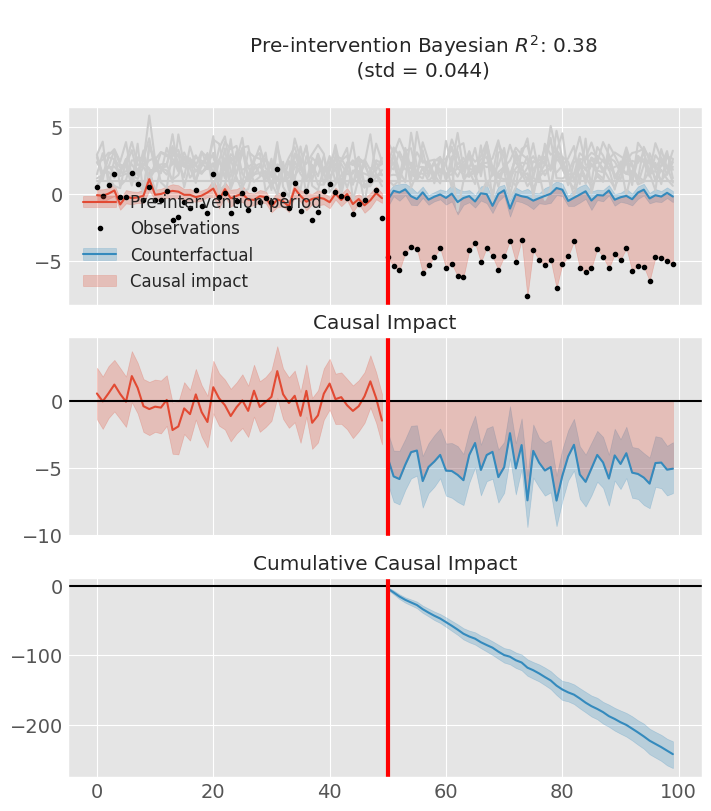

In [9]:
fig, ax = result_with_intercept.plot(plot_predictors=True)

In [10]:
result_with_intercept.print_coefficients()

Model coefficients:
    Intercept  -2.2, 94% HDI [-2.5, -1.9]
    a          0.061, 94% HDI [0.002, 0.19]
    b          0.26, 94% HDI [0.058, 0.47]
    c          0.069, 94% HDI [0.0027, 0.22]
    d          0.091, 94% HDI [0.0045, 0.25]
    e          0.11, 94% HDI [0.0073, 0.28]
    f          0.12, 94% HDI [0.0081, 0.31]
    g          0.06, 94% HDI [0.0024, 0.19]
    h          0.13, 94% HDI [0.01, 0.32]
    i          0.091, 94% HDI [0.0038, 0.27]
    sigma      0.98, 94% HDI [0.81, 1.2]


#### Пример реализации с помощью чистого pymc: 

In [41]:
treatment_time = T0

formula = "actual ~ 1 + a + b + c + d + e + f + g + h + i"

datapre = data_bayes[data_bayes.index < treatment_time]
datapost = data_bayes[data_bayes.index >= treatment_time]

y, X = dmatrices(formula, datapre)

pre_y, pre_X = np.asarray(y), np.asarray(X)


(new_y, new_x) = build_design_matrices(
    [y.design_info, X.design_info], datapost
)
post_X = np.asarray(new_x)
post_y = np.asarray(new_y)

del y, X

### надо в модель добавить что X и Y pre

# with pm.Model() as model:
#     n_predictors = X.shape[1]
#     X = pm.Data("X", X, dims=["obs_ind", "coeffs"])
#     y = pm.Data("y", y[:, 0], dims="obs_ind")
#     intercept = pm.Normal("intercept", mu=0, sigma=1)
#     beta = pm.Dirichlet("beta", a=np.ones(n_predictors-1), dims="coeffs")
#     X_without_intercept = X[:, 1:]  
#     mu = pm.Deterministic("mu", intercept + pm.math.dot(X_without_intercept, beta), dims="obs_ind")
#     sigma = pm.HalfNormal("sigma", 1)
#     pm.Normal("y_hat", mu, sigma, observed=y, dims="obs_ind")


# ### Вероятно должно быть так:
# with pm.Model() as model:
#     # Определяем размерности
#     n_predictors = pre_X.shape[1]
    
#     # Данные - используем только MutableData
#     X = pm.MutableData(name="X", value=pre_X)
#     y = pm.MutableData(name="y", value=pre_y[:, 0])
    
#     # Параметры
#     intercept = pm.Normal("intercept", mu=0, sigma=1)
#     beta = pm.Dirichlet("beta", a=np.ones(n_predictors-1), dims="coeffs")
    
#     # Среднее
#     X_without_intercept = X[:, 1:]
#     mu = pm.Deterministic("mu", intercept + pm.math.dot(X_without_intercept, beta))
    
#     # Дисперсия
#     sigma = pm.HalfNormal("sigma", 1)
    
#     # Наблюдаемые данные
#     pm.Normal("y_hat", mu, sigma, observed=y)

# with model:
#     idata = pm.sample()
#     posterior_predictive_pre = pm.sample_posterior_predictive(trace=idata)

In [42]:

with pm.Model() as model:
    # Определяем размерности
    n_predictors = pre_X.shape[1]
    
    # Данные - используем только MutableData
    X = pm.MutableData(name="X", value=pre_X)
    y = pm.MutableData(name="y", value=pre_y[:, 0])
    
    # Параметры
    intercept = pm.Normal("intercept", mu=0, sigma=1)
    beta = pm.Dirichlet("beta", a=np.ones(n_predictors-1))
    
    # Среднее
    X_without_intercept = X[:, 1:]
    mu = pm.Deterministic("mu", intercept + pm.math.dot(X_without_intercept, beta))
    
    # Дисперсия
    sigma = pm.HalfNormal("sigma", 1)
    
    # Наблюдаемые данные
    pm.Normal("y_hat", mu, sigma, observed=y)

with model:
    idata = pm.sample()
    posterior_predictive_pre = pm.sample_posterior_predictive(trace=idata)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, beta, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 10 seconds.
Sampling: [y_hat]


Output()

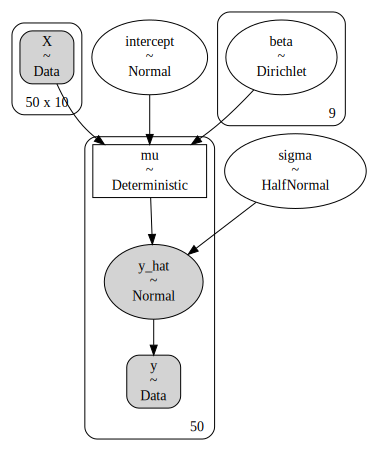

In [43]:
model.to_graphviz()

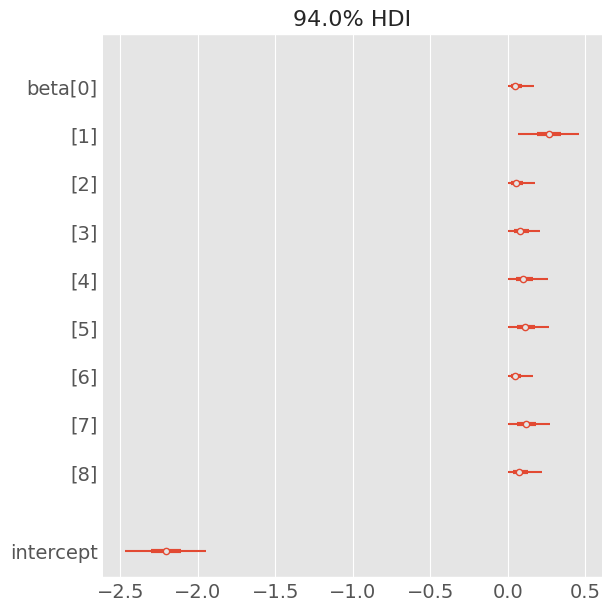

In [44]:
az.plot_forest(data=idata, combined=True, var_names=["beta", "intercept"]);

In [52]:
with model:
    pm.set_data(new_data={"X": post_X, "y": post_y[:, 0]})
    posterior_predictive_post = pm.sample_posterior_predictive(
        trace=idata, var_names=["y_hat"]
    )

Sampling: [y_hat]


Output()

In [54]:
import seaborn as sns


In [55]:
data_bayes

,actual,a,b,c,d,e,f,g,h,i
0,0.496714,0.584629,2.357787,1.171005,0.405572,2.926178,2.756989,1.477277,2.938284,2.368673
1,-0.138264,1.579355,2.560785,1.439819,1.400625,3.909417,1.077835,3.049009,1.483955,1.606661
2,0.647689,1.657285,3.083051,2.747294,2.005244,0.601432,2.869606,1.295656,2.096121,2.028745
3,1.523030,1.197723,3.053802,2.610370,2.046981,2.562969,3.355638,0.591539,1.537725,3.278452
4,-0.234153,1.838714,0.622331,1.979098,1.549935,1.349357,2.413435,0.443371,1.565504,2.191099
...,...,...,...,...,...,...,...,...,...,...
95,-6.463515,2.385317,1.307090,1.530824,2.538910,1.489984,1.690454,3.053153,2.648710,1.718900
96,-4.703880,1.116143,2.899600,0.286865,0.962754,1.730125,2.326133,1.960445,1.832882,3.797687
97,-4.738945,2.153725,2.307300,3.353872,1.809661,1.021236,0.748886,2.681501,2.146714,2.640843
98,-4.994887,2.058209,2.812862,1.885460,1.124382,1.555707,2.924027,2.028318,3.206509,1.428821


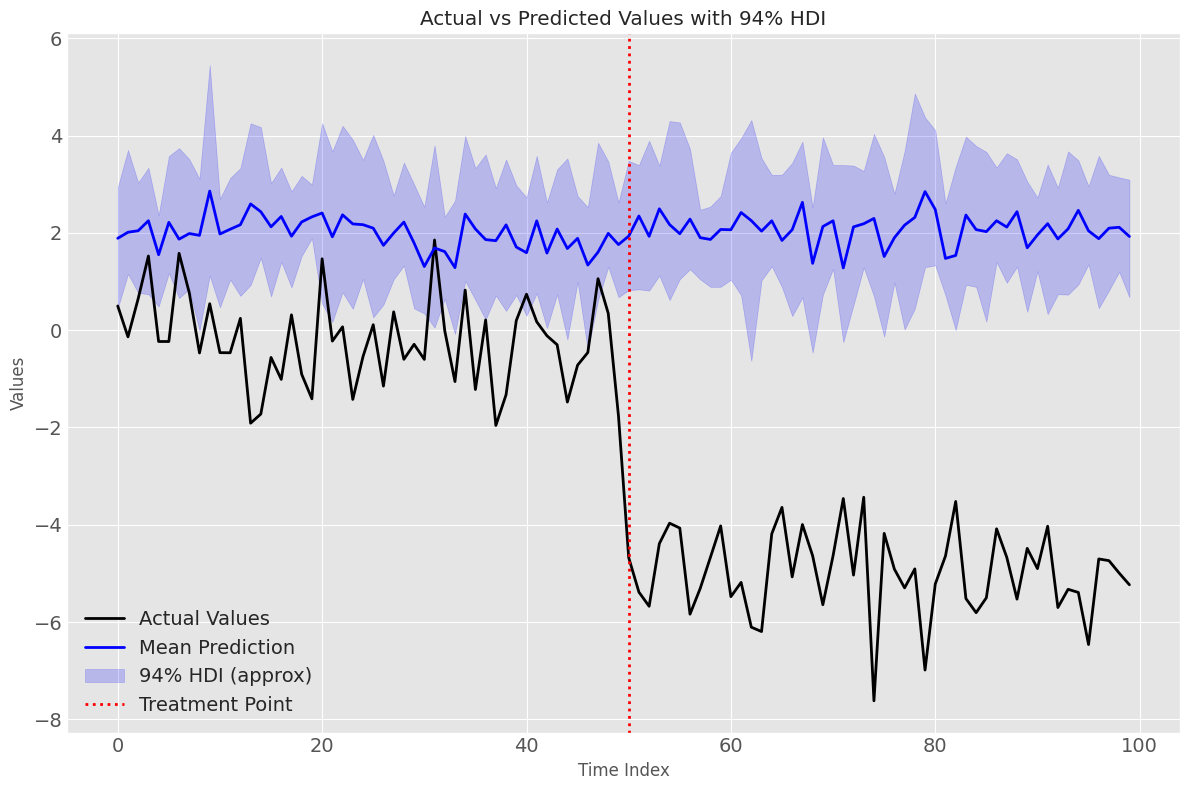

In [57]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Assuming data_bayes is already loaded
# If not, load it with: data_bayes = pd.read_csv('path_to_data_bayes.csv')

# Define pre and post treatment periods (assuming 50/50 split)
T0 = 50  # Treatment time point
pre_period = data_bayes.index[:T0]
post_period = data_bayes.index[T0:]

# Extract actual values
actual_values = data_bayes['actual']

# Define predictor columns (models)
predictors = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i']

# Calculate mean prediction across all models
predicted_mean = data_bayes[predictors].mean(axis=1)

# Calculate HDI (using quantiles as approximation)
lower_hdi = data_bayes[predictors].quantile(0.03, axis=1)
upper_hdi = data_bayes[predictors].quantile(0.97, axis=1)

# Create the plot
fig, ax = plt.subplots(figsize=(12, 8))

# Plot actual values
sns.lineplot(
    x=data_bayes.index, 
    y=actual_values, 
    label='Actual Values', 
    color='black', 
    linewidth=2, 
    ax=ax
)

# Plot mean prediction
sns.lineplot(
    x=data_bayes.index, 
    y=predicted_mean, 
    label='Mean Prediction', 
    color='blue', 
    linewidth=2, 
    ax=ax
)

# Add HDI band
ax.fill_between(
    data_bayes.index, 
    lower_hdi, 
    upper_hdi, 
    color='blue', 
    alpha=0.2, 
    label='94% HDI (approx)'
)

# Add vertical line at treatment point
ax.axvline(
    x=T0, 
    linestyle=':', 
    lw=2, 
    color='red', 
    label='Treatment Point'
)

# Set labels and title
ax.set_xlabel('Time Index')
ax.set_ylabel('Values')
ax.set_title('Actual vs Predicted Values with 94% HDI')
ax.legend(loc='best')

plt.tight_layout()
plt.show()

добить для интереса: https://juanitorduz.github.io/synthetic_control_pymc/

### Bayesian R2D2 Synthetic Control example

ну может не R2D2 но гауссовский крутани процесс

In [ ]:
treatment_time = T0

formula = "actual ~ 1 + a + b + c + d + e + f + g + h + i"

datapre = data_bayes[data_bayes.index < treatment_time]
datapost = data_bayes[data_bayes.index >= treatment_time]

y, X = dmatrices(formula, datapre)

pre_y, pre_X = np.asarray(y), np.asarray(X)


(new_y, new_x) = build_design_matrices(
    [y.design_info, X.design_info], datapost
)
post_X = np.asarray(new_x)
post_y = np.asarray(new_y)


with pm.Model() as model:
    n_predictors = X.shape[1]
    X = pm.Data("X", X, dims=["obs_ind", "coeffs"])
    y = pm.Data("y", y[:, 0], dims="obs_ind")
    intercept = pm.Normal("intercept", mu=0, sigma=1)
    beta = pm.Dirichlet("beta", a=np.ones(n_predictors-1), dims="coeffs")
    X_without_intercept = X[:, 1:]  
    mu = pm.Deterministic("mu", intercept + pm.math.dot(X_without_intercept, beta), dims="obs_ind")
    sigma = pm.HalfNormal("sigma", 1)
    pm.Normal("y_hat", mu, sigma, observed=y, dims="obs_ind")

with model:
    trace = pm.sample(return_inferencedata=True)